# News topic classification

In [ ]:
import os, random, math, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import tensorflow as tf
import tensorflow_hub as hub
import tf_keras
from tf_keras.layers import TextVectorization, Embedding

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
# Paths
BASE_DIR = "/content"
DATA_DIR = os.path.join(BASE_DIR, "data")
PROC_DIR = os.path.join(DATA_DIR, "processed")
os.makedirs(PROC_DIR, exist_ok=True)

## Download AG News via Datasets

In [ ]:
ag_news = load_dataset("ag_news")
ag_news

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

## Normalize into dataframe

In [ ]:
# Label map
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}

def to_df(ds_split):
    df = pd.DataFrame(ds_split)
    # Ensure columns exist
    assert "text" in df.columns and "label" in df.columns
    df["label_name"] = df["label"].map(label_map)
    # Basic cleanup (minimal)
    df["text"] = df["text"].str.strip()
    return df[["text", "label", "label_name"]]

train_df_raw = to_df(ag_news["train"])
test_df = to_df(ag_news["test"])

train_df_raw.head()


,text,label,label_name
0,Wall St. Bears Claw Back Into the Black (Reute...,2,Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,Business
4,"Oil prices soar to all-time record, posing new...",2,Business


## Create a stratified validation split (10% of train)

In [ ]:
train_df, val_df = train_test_split(
    train_df_raw,
    test_size=0.10,
    stratify=train_df_raw["label"],
    random_state=SEED
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

Train: (108000, 3) Val: (12000, 3) Test: (7600, 3)


In [ ]:
# Save to CSVs for reproducibility
train_df.to_csv(os.path.join(PROC_DIR, "train.csv"), index=False)
val_df.to_csv(os.path.join(PROC_DIR, "val.csv"), index=False)
test_df.to_csv(os.path.join(PROC_DIR, "test.csv"), index=False)

In [ ]:
# Data Card basics
with open(os.path.join(PROC_DIR, "data_card.txt"), "w") as f:
    f.write(
        "Dataset: AG News\n"
        "Task: Multi-class topic classification (4 classes)\n"
        f"Splits: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}\n"
        f"Labels: {label_map}\n"
        f"Seed: {SEED}\n"
    )

## Check label balance

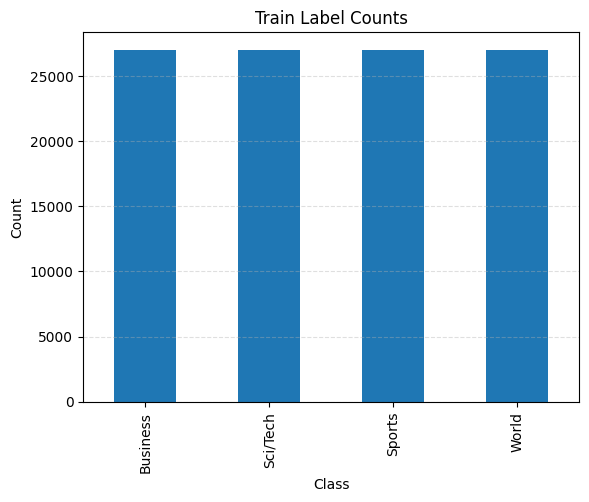

In [ ]:
def plot_label_counts(df, title):
    counts = df["label_name"].value_counts().sort_index()
    plt.figure()
    counts.plot(kind="bar")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.show()

plot_label_counts(train_df, "Train Label Counts")

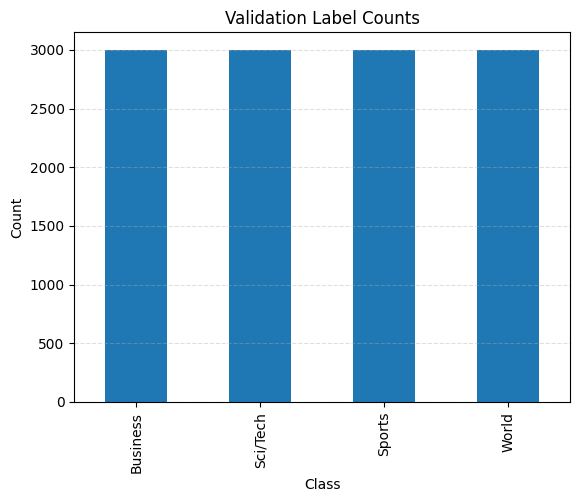

In [ ]:
plot_label_counts(val_df, "Validation Label Counts");

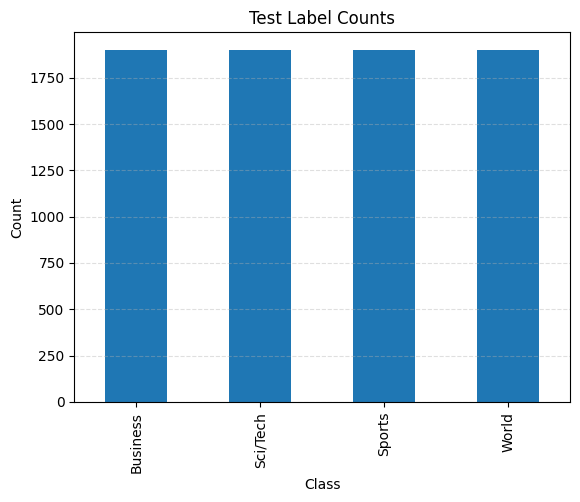

In [ ]:
plot_label_counts(test_df, "Test Label Counts")

In [ ]:
pd.concat([
    train_df["label_name"].value_counts(normalize=True).rename("train"),
    val_df["label_name"].value_counts(normalize=True).rename("val"),
    test_df["label_name"].value_counts(normalize=True).rename("test"),
], axis=1).round(3)

,train,val,test
label_name,,,
Sports,0.25,0.25,0.25
Business,0.25,0.25,0.25
Sci/Tech,0.25,0.25,0.25
World,0.25,0.25,0.25


## EDA

### Text length distributions (tokens & characters)

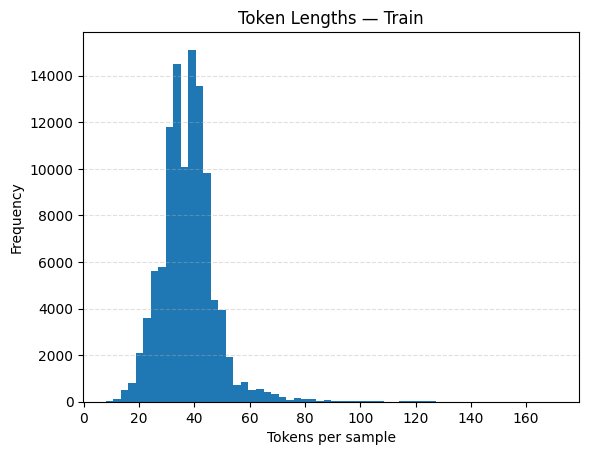

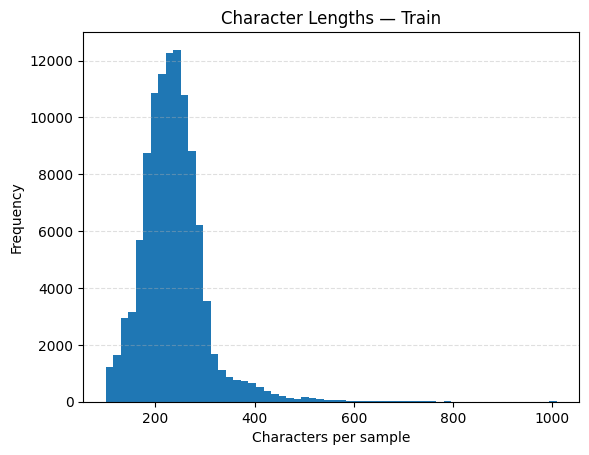

Token length percentiles (train): [37. 43. 48. 53. 70.]
Char length percentiles  (train): [232. 266. 300. 343. 465.]


In [ ]:
# Tokenize quickly by whitespace just for EDA
def length_stats(df):
    tokens = df["text"].str.split()
    token_lens = tokens.map(len)
    char_lens  = df["text"].str.len()
    return token_lens, char_lens

train_tok_lens, train_char_lens = length_stats(train_df)
val_tok_lens, val_char_lens = length_stats(val_df)
test_tok_lens, test_char_lens = length_stats(test_df)


def hist(data, title, bins=50, xlab="Length"):
    plt.figure()
    plt.hist(data, bins=bins)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.show()


hist(train_tok_lens, "Token Lengths — Train", bins=60, xlab="Tokens per sample")
hist(train_char_lens, "Character Lengths — Train", bins=60, xlab="Characters per sample")

print("Token length percentiles (train):", np.percentile(train_tok_lens, [50, 75, 90, 95, 99]))
print("Char length percentiles  (train):", np.percentile(train_char_lens, [50, 75, 90, 95, 99]))

### Per-class length stats (spot harder classes)

In [ ]:
def per_class_length_table(df):
    lens = df["text"].str.split().map(len)
    tbl = df.assign(tokens=lens).groupby("label_name")["tokens"].describe()[["count","mean","50%","75%","max"]]
    return tbl.rename(columns={"50%":"p50","75%":"p75"})

per_class_length_table(train_df)

,count,mean,p50,p75,max
label_name,,,,,
Business,27000.0,37.550778,37.0,42.0,134.0
Sci/Tech,27000.0,37.236259,36.0,43.0,171.0
Sports,27000.0,37.755667,37.0,42.0,151.0
World,27000.0,38.879296,39.0,44.0,145.0


### Peeking at samples (by class)

In [ ]:
def show_examples(df, label_name, k=3, width=90):
    subset = df[df["label_name"] == label_name].sample(k, random_state=SEED)
    for i, row in subset.reset_index(drop=True).iterrows():
        print(f"[{label_name}] Example {i+1}:")
        print(textwrap.fill(row["text"], width=width))
        print("-"*80)

for cls in label_map.values():
    show_examples(train_df, cls, k=2, width=100)

[World] Example 1:
Spain busts a suspected Muslim terror ring Eight Muslim terrorists planning to detonate a
1,100-pound bomb near a federal court in Madrid have been arrested, Spanish officials say.
--------------------------------------------------------------------------------
[World] Example 2:
Iraq Airways heads past borders Iraqi Airways is reportedly planning to restart international
flights after a 14-year break on Saturday.
--------------------------------------------------------------------------------
[Sports] Example 1:
Hamm allowed to hold his gold Two months after a judging error overshadowed one of the most stunning
comebacks in Olympic history, Paul Hamm is no longer stuck in limbo.
--------------------------------------------------------------------------------
[Sports] Example 2:
Gasquet reaches first ATP Tour final in Metz France #39;s Richard Gasquet brushed aside American
Jeff Morrison 6-1 6-4 in the Metz Open on Saturday to reach his first final of an ATP Tour
tou

In [ ]:
summary = pd.DataFrame({
    "split": ["train","val","test"],
    "size": [len(train_df), len(val_df), len(test_df)],
})
label_dist = train_df["label_name"].value_counts(normalize=True).rename("train_prop")
summary.to_csv(os.path.join(PROC_DIR, "split_sizes.csv"), index=False)
label_dist.to_csv(os.path.join(PROC_DIR, "train_label_distribution.csv"))
summary, label_dist.round(3)

(   split    size
 0  train  108000
 1    val   12000
 2   test    7600,
 label_name
 Sports      0.25
 Business    0.25
 Sci/Tech    0.25
 World       0.25
 Name: train_prop, dtype: float64)

In [ ]:
train_df.head()

,text,label,label_name
6836,10 seconds that change everything ATHENS - Ten...,1,Sports
90699,Charline Labonte rises to challenge Charline L...,1,Sports
65214,Ex-El Paso Traders Plead Guilty to False Repor...,2,Business
87713,Brit deal #39;one year only Even if British a...,1,Sports
109406,"Signed, Sealed, Delivered CHICAGO - The Cubs a...",1,Sports


## Split into sentences and labels

In [ ]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

In [ ]:
train_sentences[:3]

['10 seconds that change everything ATHENS - Ten seconds. Barely time enough to tie a shoe, wash a glass, get the paper off the porch. But when the moment comes, and eight men kneel at their blocks and peer down the empty, waiting track, it is as if the entire Olympics stop to watch.',
 'Charline Labonte rises to challenge Charline Labonte has served notice she wants to become the next starting goaltender of the Canadian women #39;s hockey team. The 22-year-old from Boisbriand, Que.',
 'Ex-El Paso Traders Plead Guilty to False Reports Two more former natural gas traders for El Paso Corp. have pleaded guilty to reporting bogus deals in a widening investigation of the industry, the US Attorney #39;s Office said.']

### One-hot labels

In [ ]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["label_name"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["label_name"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["label_name"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

### Label encode labels

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["label_name"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["label_name"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["label_name"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([2, 2, 0, ..., 0, 2, 0])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(4, array(['Business', 'Sci/Tech', 'Sports', 'World'], dtype=object))

## Modelling experiments

In [ ]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

### Model 0: Baseline (TF-IDF Multinomial Naive Bayes classifier)

In [ ]:
# Create tokenization pipeline
model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
  ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                 y=val_labels_encoded)

0.9085833333333333

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 3, 0, 2, 3, 1, 3, 0, 3])

In [ ]:
val_labels_encoded

array([1, 1, 3, ..., 3, 3, 1])

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 90.85833333333333,
 'precision': 0.9082643047558148,
 'recall': 0.9085833333333333,
 'f1': 0.9083307085643197}

### Creating TextVectorization and Custom Text Embedding

#### TextVectorization

In [ ]:
output_seq_len = 53

text_vectorizer = TextVectorization(output_sequence_length=output_seq_len,
                                    standardize='lower_and_strip_punctuation',
                                    split='whitespace')

text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
target_sentence = random.choice(train_sentences)
print(f"Target sentence: {target_sentence}")
print(f"Length of target sentence: {len(target_sentence.split())}")
print(f"Vectorized target sentence: {text_vectorizer([target_sentence])}")

Target sentence: NBA Wrap: Hamilton Guides Pistons to Win Over Cavs Richard Hamilton posted 21 points to propel the Detroit Pistons to an 81-69 triumph over the Cleveland Cavaliers at Auburn Hills, Michigan Thursday.
Length of target sentence: 32
Vectorized target sentence: [[  829  1861  3014  9066  2665     3    98    33  6791  1910  3014   668
    657   320     3 10069     2   962  2665     3    25 26092  3440    33
      2  1497  3221    14  2083  2103  1404    49     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]


In [ ]:
# How many words in training vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(text_vocab)}")
print(f"Top 5 words: {text_vocab[:5]}")
print(f"Bottom 5 words: {text_vocab[-5:]}")

Number of words in vocab: 96957
Top 5 words: ['', '[UNK]', np.str_('the'), np.str_('to'), np.str_('a')]
Bottom 5 words: [np.str_('0032'), np.str_('0029'), np.str_('0013'), np.str_('000th'), np.str_('000660se')]


#### Custom text embedding

In [ ]:
# Create token embedding layer
token_embed = Embedding(input_dim=len(text_vocab),
                        output_dim=128,
                        mask_zero=True, # use masking to handle variable sequence lengths (save space)
                        name="token_embedding")

#### Character-level tokenizer

In [ ]:
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
output_seq_char_len = 343

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_mode="int",
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of characters in vocab: 38
5 most common characters: ['', '[UNK]', np.str_('e'), np.str_('a'), np.str_('t')]
5 least common characters: [np.str_('5'), np.str_('4'), np.str_('6'), np.str_('7'), np.str_('8')]


#### Character-level embedding

In [ ]:
# Create char embedding layer
char_embed = tf_keras.layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embedding")

### Creating datasets

#### Token datsets

In [ ]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(4,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 4), dtype=tf.float64, name=None))>

#### Char datasets

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

#### Token and character datasets

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### Model 1: A simple dense model

In [ ]:
inputs = tf_keras.layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional
x = text_vectorizer(inputs) # turn the input text into numbers
x = token_embed(x) # create an embedding of the numberized inputs
x = tf_keras.layers.GlobalAveragePooling1D(name="global_avg_pool_layer")(x)
outputs = tf_keras.layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf_keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 53)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 53, 128)           12410496  
 )                                                               
                                                                 
 global_avg_pool_layer (Glo  (None, 128)               0         
 balAveragePooling1D)                                            
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                     

In [ ]:
# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_1 = model_1.fit(train_dataset,
                        epochs=5,
                        validation_data=val_dataset)

Epoch 1/5
3375/3375 [==============================] - 48s 14ms/step - loss: 0.3684 - accuracy: 0.8984 - val_loss: 0.2456 - val_accuracy: 0.9220
Epoch 2/5
3375/3375 [==============================] - 19s 6ms/step - loss: 0.1817 - accuracy: 0.9401 - val_loss: 0.2424 - val_accuracy: 0.9218
Epoch 3/5
3375/3375 [==============================] - 19s 6ms/step - loss: 0.1302 - accuracy: 0.9563 - val_loss: 0.2620 - val_accuracy: 0.9193
Epoch 4/5
3375/3375 [==============================] - 19s 6ms/step - loss: 0.0981 - accuracy: 0.9670 - val_loss: 0.2927 - val_accuracy: 0.9156
Epoch 5/5
3375/3375 [==============================] - 19s 6ms/step - loss: 0.0761 - accuracy: 0.9752 - val_loss: 0.3292 - val_accuracy: 0.9117


In [ ]:
# Check the results
model_1.evaluate(val_dataset)

375/375 [==============================] - 1s 3ms/step - loss: 0.3292 - accuracy: 0.9117


[0.32917243242263794, 0.9116666913032532]

In [ ]:
# Make predictions (model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs[:5]

375/375 [==============================] - 1s 2ms/step


array([[8.41194451e-01, 1.58715412e-01, 1.18774174e-07, 9.00434097e-05],
       [6.57028258e-01, 3.32937628e-01, 1.93609309e-03, 8.09807517e-03],
       [4.69351608e-06, 1.30980870e-05, 3.75185596e-06, 9.99978542e-01],
       [9.54251587e-01, 1.64922471e-06, 2.16356675e-08, 4.57468182e-02],
       [4.25117202e-02, 6.11606170e-04, 8.85523200e-01, 7.13534281e-02]],
      dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 0, 2])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 91.16666666666666,
 'precision': 0.9114847895371181,
 'recall': 0.9116666666666666,
 'f1': 0.9115030673169268}

### Model 2: LSTM

In [ ]:
inputs = tf_keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = tf_keras.layers.LSTM(units=64)(x)
outputs = tf_keras.layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf_keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
callbacks_2 = [
    tf_keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf_keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, cooldown=0, min_lr=1e-6)
]

In [ ]:
history_2 = model_2.fit(train_dataset,
                        epochs=20,
                        validation_data=val_dataset,
                        callbacks=callbacks_2)

Epoch 1/20
3375/3375 [==============================] - 69s 19ms/step - loss: 0.0956 - accuracy: 0.9703 - val_loss: 0.3717 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 2/20
3375/3375 [==============================] - 35s 10ms/step - loss: 0.0621 - accuracy: 0.9798 - val_loss: 0.3912 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 3/20
3375/3375 [==============================] - 35s 10ms/step - loss: 0.0351 - accuracy: 0.9885 - val_loss: 0.4618 - val_accuracy: 0.8979 - lr: 5.0000e-04
Epoch 4/20
3375/3375 [==============================] - 35s 10ms/step - loss: 0.0210 - accuracy: 0.9933 - val_loss: 0.5113 - val_accuracy: 0.8966 - lr: 2.5000e-04


In [ ]:
# Check the results
model_2.evaluate(val_dataset)

375/375 [==============================] - 2s 5ms/step - loss: 0.3717 - accuracy: 0.8982


[0.3717256188392639, 0.8981666564941406]

In [ ]:
model_2_pred_probs = model_2.predict(val_dataset)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

375/375 [==============================] - 3s 4ms/step


{'accuracy': 89.81666666666666,
 'precision': 0.8984152239375102,
 'recall': 0.8981666666666667,
 'f1': 0.8980513789631273}

### Model 3: GRU

In [ ]:
inputs = tf_keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = token_embed(x)
x = tf_keras.layers.GRU(64)(x)
outputs = tf_keras.layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf_keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
callbacks_3 = [
    tf_keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf_keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, cooldown=0, min_lr=1e-6)
]

In [ ]:
history_3 = model_3.fit(train_dataset,
                        epochs=20,
                        validation_data=val_dataset,
                        callbacks=callbacks_3)

Epoch 1/20
3375/3375 [==============================] - 68s 19ms/step - loss: 0.0843 - accuracy: 0.9723 - val_loss: 0.4102 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 2/20
3375/3375 [==============================] - 35s 10ms/step - loss: 0.0512 - accuracy: 0.9834 - val_loss: 0.4687 - val_accuracy: 0.8923 - lr: 0.0010
Epoch 3/20
3375/3375 [==============================] - 33s 10ms/step - loss: 0.0317 - accuracy: 0.9896 - val_loss: 0.5238 - val_accuracy: 0.8914 - lr: 5.0000e-04
Epoch 4/20
3375/3375 [==============================] - 34s 10ms/step - loss: 0.0184 - accuracy: 0.9943 - val_loss: 0.5815 - val_accuracy: 0.8938 - lr: 2.5000e-04


In [ ]:
model_3.evaluate(val_dataset)

375/375 [==============================] - 2s 5ms/step - loss: 0.4102 - accuracy: 0.8967


[0.4101807475090027, 0.8967499732971191]

In [ ]:
model_3_pred_probs = model_3.predict(val_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

375/375 [==============================] - 3s 5ms/step


{'accuracy': 89.67500000000001,
 'precision': 0.8975512704440906,
 'recall': 0.89675,
 'f1': 0.8966065022034351}

### Model 4: Bidirectional RNN (LSTM)

In [ ]:
inputs = tf_keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = token_embed(x)
x = tf_keras.layers.Bidirectional(tf_keras.layers.LSTM(64))(x)
outputs = tf_keras.layers.Dense(num_classes, activation="softmax")(x)
model_4 = tf_keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
callbacks_4 = [
    tf_keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf_keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, cooldown=0, min_lr=1e-6)
]

In [ ]:
history_4 = model_4.fit(train_dataset,
                        epochs=20,
                        validation_data=val_dataset,
                        callbacks=callbacks_4)

Epoch 1/20
3375/3375 [==============================] - 87s 24ms/step - loss: 0.0666 - accuracy: 0.9797 - val_loss: 0.3885 - val_accuracy: 0.8987 - lr: 0.0010
Epoch 2/20
3375/3375 [==============================] - 48s 14ms/step - loss: 0.0463 - accuracy: 0.9846 - val_loss: 0.4594 - val_accuracy: 0.8945 - lr: 0.0010
Epoch 3/20
3375/3375 [==============================] - 48s 14ms/step - loss: 0.0267 - accuracy: 0.9911 - val_loss: 0.5079 - val_accuracy: 0.8942 - lr: 5.0000e-04
Epoch 4/20
3375/3375 [==============================] - 48s 14ms/step - loss: 0.0156 - accuracy: 0.9950 - val_loss: 0.5774 - val_accuracy: 0.8928 - lr: 2.5000e-04


In [ ]:
model_4_pred_probs = model_4.predict(val_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

375/375 [==============================] - 4s 5ms/step


{'accuracy': 89.86666666666666,
 'precision': 0.8985653833198124,
 'recall': 0.8986666666666666,
 'f1': 0.8984384944944859}

### Model 5: Conv1D with token embeddings

In [ ]:
inputs = tf_keras.layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = tf_keras.layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = tf_keras.layers.GlobalAveragePooling1D()(x)
outputs = tf_keras.layers.Dense(num_classes, activation="softmax")(x)
model_5 = tf_keras.Model(inputs, outputs, name="model_5_conv1d")

# Compile
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
callbacks_5 = [
    tf_keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    tf_keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, cooldown=0, min_lr=1e-6)
]

In [ ]:
history_5 = model_5.fit(train_dataset,
                        epochs=20,
                        validation_data=val_dataset,
                        callbacks=callbacks_5)

Epoch 1/20
3375/3375 [==============================] - 50s 14ms/step - loss: 0.0713 - accuracy: 0.9799 - val_loss: 0.4344 - val_accuracy: 0.8975 - lr: 0.0010
Epoch 2/20
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0441 - accuracy: 0.9861 - val_loss: 0.5170 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 3/20
3375/3375 [==============================] - 20s 6ms/step - loss: 0.0301 - accuracy: 0.9903 - val_loss: 0.5816 - val_accuracy: 0.8936 - lr: 5.0000e-04
Epoch 4/20
3375/3375 [==============================] - 20s 6ms/step - loss: 0.0201 - accuracy: 0.9940 - val_loss: 0.6371 - val_accuracy: 0.8942 - lr: 2.5000e-04


In [ ]:
model_5_pred_probs = model_5.predict(val_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

375/375 [==============================] - 1s 3ms/step


{'accuracy': 89.75,
 'precision': 0.8972325277224041,
 'recall': 0.8975,
 'f1': 0.8972920499820528}

### Model 6: Feature extraction with pretrained token embeddings

In [ ]:
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                 trainable=False,
                                 name="universal_sentence_encoder")

In [ ]:
inputs = tf_keras.layers.Input(shape=[], dtype=tf.string, name="input_layer")
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence
x = tf_keras.layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = tf_keras.layers.Dense(num_classes, activation="softmax")(x)
model_6 = tf_keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

# Compile
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
callbacks_6 = [
    tf_keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True),
    tf_keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-6)
]

In [ ]:
history_6 = model_6.fit(train_dataset,
                        epochs=10,
                        validation_data=val_dataset,
                        callbacks=callbacks_5)

Epoch 1/10
3375/3375 [==============================] - 52s 14ms/step - loss: 0.3205 - accuracy: 0.8915 - val_loss: 0.2828 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 2/10
3375/3375 [==============================] - 47s 14ms/step - loss: 0.2745 - accuracy: 0.9025 - val_loss: 0.2697 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/10
3375/3375 [==============================] - 46s 14ms/step - loss: 0.2567 - accuracy: 0.9093 - val_loss: 0.2624 - val_accuracy: 0.9097 - lr: 0.0010
Epoch 4/10
3375/3375 [==============================] - 47s 14ms/step - loss: 0.2415 - accuracy: 0.9150 - val_loss: 0.2581 - val_accuracy: 0.9117 - lr: 0.0010
Epoch 5/10
3375/3375 [==============================] - 46s 14ms/step - loss: 0.2279 - accuracy: 0.9202 - val_loss: 0.2560 - val_accuracy: 0.9129 - lr: 0.0010
Epoch 6/10
3375/3375 [==============================] - 45s 13ms/step - loss: 0.2157 - accuracy: 0.9248 - val_loss: 0.2566 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 7/10
3375/3375 [========================

In [ ]:
model_6_pred_probs = model_6.predict(val_dataset)
model_6_preds = tf.argmax(model_6_pred_probs, axis=1)
model_6_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_6_preds)
model_6_results

375/375 [==============================] - 4s 10ms/step


{'accuracy': 91.60833333333333,
 'precision': 0.9166173764860259,
 'recall': 0.9160833333333334,
 'f1': 0.9159799113855389}

### Model 7: Conv1D with character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = tf_keras.layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = tf_keras.layers.Conv1D(filters=64, kernel_size=5, activation="relu")(char_embeddings)
x = tf_keras.layers.GlobalAveragePooling1D()(x)
outputs = tf_keras.layers.Dense(num_classes, activation="softmax")(x)
model_7 = tf_keras.Model(inputs=inputs, outputs=outputs, name="model_7_conv1d_char_embeddings")

# Compile
model_7.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
callbacks_7 = [
    tf_keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True, min_delta=1e-4),
    tf_keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-6)
]

In [ ]:
# Fit the model on chars only
history_7 = model_7.fit(train_char_dataset,
                        epochs=25,
                        validation_data=val_char_dataset,
                        callbacks=callbacks_7)

Epoch 1/25
3375/3375 [==============================] - 20s 6ms/step - loss: 1.1427 - accuracy: 0.4989 - val_loss: 1.0958 - val_accuracy: 0.5328 - lr: 0.0010
Epoch 2/25
3375/3375 [==============================] - 18s 5ms/step - loss: 1.0598 - accuracy: 0.5511 - val_loss: 1.0527 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 3/25
3375/3375 [==============================] - 18s 5ms/step - loss: 1.0067 - accuracy: 0.5821 - val_loss: 0.9855 - val_accuracy: 0.5951 - lr: 0.0010
Epoch 4/25
3375/3375 [==============================] - 18s 5ms/step - loss: 0.9315 - accuracy: 0.6223 - val_loss: 0.9104 - val_accuracy: 0.6317 - lr: 0.0010
Epoch 5/25
3375/3375 [==============================] - 18s 5ms/step - loss: 0.8603 - accuracy: 0.6572 - val_loss: 0.8484 - val_accuracy: 0.6647 - lr: 0.0010
Epoch 6/25
3375/3375 [==============================] - 18s 5ms/step - loss: 0.7990 - accuracy: 0.6890 - val_loss: 0.7944 - val_accuracy: 0.6897 - lr: 0.0010
Epoch 7/25
3375/3375 [==============================

In [ ]:
model_7_pred_probs = model_7.predict(val_char_dataset)
model_7_preds = tf.argmax(model_7_pred_probs, axis=1)
model_7_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_7_preds)
model_7_results

375/375 [==============================] - 1s 3ms/step


{'accuracy': 83.00833333333333,
 'precision': 0.8321669725043298,
 'recall': 0.8300833333333333,
 'f1': 0.8289444746599313}

### Model 8: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

In [ ]:
# 1. Setup token inputs/model
token_inputs = tf_keras.layers.Input(shape=(), dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf_keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf_keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Setup character inputs/model
char_inputs = tf_keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf_keras.layers.Bidirectional(tf_keras.layers.LSTM(24))(char_embeddings)
char_model = tf_keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf_keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = tf_keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf_keras.layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = tf_keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf_keras.layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct final model
model_8 = tf_keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_8_token_and_char_embeddings")

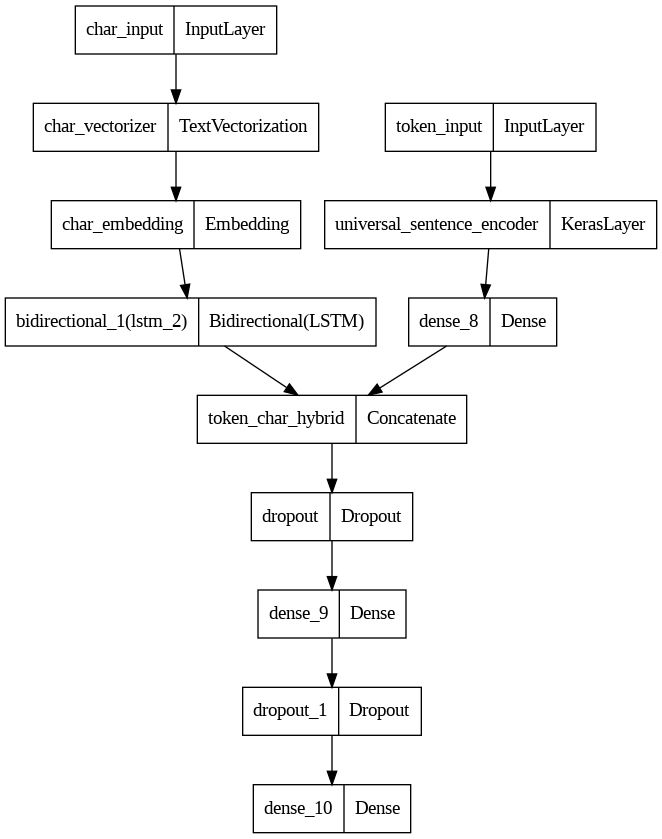

In [ ]:
tf_keras.utils.plot_model(model_8)

In [ ]:
# Compile token char model
model_8.compile(loss="categorical_crossentropy",
                optimizer=tf_keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
callbacks_8 = [
    tf_keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    tf_keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-6)
]

In [ ]:
# Fit the model on tokens and chars
history_8 = model_8.fit(train_char_token_dataset,
                        epochs=25,
                        validation_data=val_char_token_dataset,
                        callbacks=callbacks_8)

Epoch 1/25
3375/3375 [==============================] - 137s 38ms/step - loss: 0.3612 - accuracy: 0.8783 - val_loss: 0.2835 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 2/25
3375/3375 [==============================] - 121s 36ms/step - loss: 0.3036 - accuracy: 0.8968 - val_loss: 0.2695 - val_accuracy: 0.9059 - lr: 0.0010
Epoch 3/25
3375/3375 [==============================] - 122s 36ms/step - loss: 0.2894 - accuracy: 0.9008 - val_loss: 0.2606 - val_accuracy: 0.9094 - lr: 0.0010
Epoch 4/25
3375/3375 [==============================] - 122s 36ms/step - loss: 0.2779 - accuracy: 0.9050 - val_loss: 0.2570 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 5/25
3375/3375 [==============================] - 122s 36ms/step - loss: 0.2682 - accuracy: 0.9075 - val_loss: 0.2534 - val_accuracy: 0.9138 - lr: 0.0010
Epoch 6/25
3375/3375 [==============================] - 126s 37ms/step - loss: 0.2611 - accuracy: 0.9105 - val_loss: 0.2521 - val_accuracy: 0.9134 - lr: 0.0010
Epoch 7/25
3375/3375 [==================

In [ ]:
model_8_pred_probs = model_8.predict(val_char_token_dataset)
model_8_preds = tf.argmax(model_8_pred_probs, axis=1)
model_8_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_8_preds)
model_8_results

375/375 [==============================] - 10s 21ms/step


{'accuracy': 92.05,
 'precision': 0.9207611631710539,
 'recall': 0.9205,
 'f1': 0.9203953058616458}

## Comparing models results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "model_1_simple_dense_model": model_1_results,
                                  "model_2_lstm": model_2_results,
                                  "model_3_gru": model_3_results,
                                  "model_4_bidirectional_rnn": model_4_results,
                                  "model_5_conv1d_token_embed": model_5_results,
                                  "model_6_feature_extraction": model_6_results,
                                  "model_7_conv1d_char_embed": model_7_results,
                                  "model_8_hybrid_embed": model_8_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,90.858333,0.908264,0.908583,0.908331
model_1_simple_dense_model,91.166667,0.911485,0.911667,0.911503
model_2_lstm,89.816667,0.898415,0.898167,0.898051
model_3_gru,89.675000,0.897551,0.896750,0.896607
model_4_bidirectional_rnn,89.866667,0.898565,0.898667,0.898438
model_5_conv1d_token_embed,89.750000,0.897233,0.897500,0.897292
model_6_feature_extraction,91.608333,0.916617,0.916083,0.915980
model_7_conv1d_char_embed,83.008333,0.832167,0.830083,0.828944
model_8_hybrid_embed,92.050000,0.920761,0.920500,0.920395


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

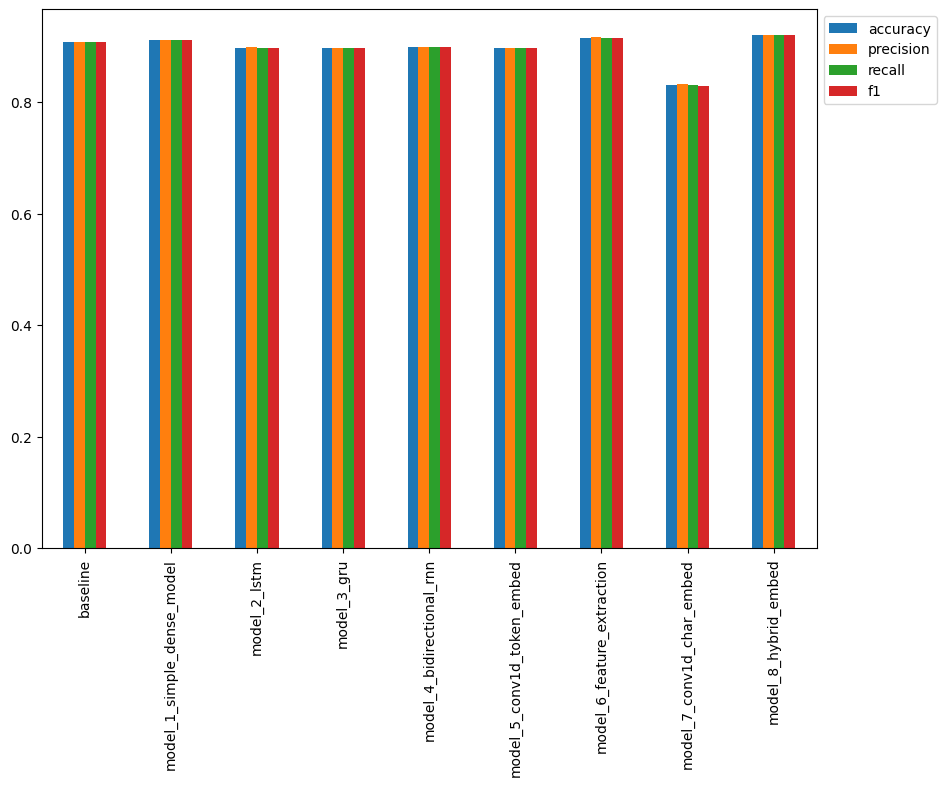

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

## Saving a model

In [ ]:
model_8.save("hybrid_model")

## Prediction on a test set

In [ ]:
model_6_test_probs = model_6.predict(test_dataset)
model_6_test_preds = tf.argmax(model_6_test_probs, axis=1)
model_6_test_results = calculate_results(y_true=test_labels_encoded,
                                         y_pred=model_6_test_preds)
model_6_test_results

238/238 [==============================] - 4s 15ms/step


{'accuracy': 91.0657894736842,
 'precision': 0.9110962253124765,
 'recall': 0.9106578947368421,
 'f1': 0.910575594073962}